# Example Notebook For Associating Experimental Signals With The Carbon Network
Prior to running this notebook, the CarbonNetwork graphml file must be present in the build folder

In [1]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import networkx as nx
import os
import glob

from typing import List, Tuple

from tqdm.notebook import tqdm

sys.path.insert(0,'/global/homes/b/bpb/repos/carbon_network/carbon_network/build')

import build_tools as wt

# replace with submodules
import sys
sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.io import feature_tools as ft
sys.path.insert(0,'/global/homes/b/bpb/repos/blink')
import blink

import analysis_tools as at

INFO:rdkit:Enabling RDKit 2023.09.1 jupyter extensions


## Parameters
The next code block sets parameters that are used throughout the remainder of the notebook.

In [2]:
all_df = pd.read_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/all_spectra_backup.pkl')


In [179]:
len(all_df['massive_id'].unique())

55

In [15]:

# tolerance in ppm between experimental signal and node mz
mz_ppm_tolerance = 5
peak_height_min = 1e4
num_datapoints_min = 10
# minimum MSMS score 
msms_score_min = 0.5

# minimum MSMS matching ion count
msms_matches_min = 3

# retention time range in minutes for feature finding
rt_range = [1, 700]

# tolerance in daltons used for calculating MS/MS similarity scores
frag_mz_tolerance = 0.05

In [4]:
uni_df = pd.read_csv('Zark_Dittmar_DOM_struct-fingerpr.tab', sep='\t',skiprows=20)
len(uni_df['Formula (of source compound)'].unique())
# uni_df.columns

54

In [65]:
spec_slice = all_df[all_df['predicted_formula']=='C16H14O10'].copy()
spec_slice['spectrum_nl_spectra'] = spec_slice.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
nl_data_spectra = spec_slice['spectrum_nl_spectra'].tolist()
data_pmzs = spec_slice['precursor_mz'].tolist()
data_pmzs[0]

365.0505041699762

In [157]:
all_df.columns

Index(['original_index', 'no_extension', 'h5', 'buddy', 'data_dir',
       'massive_id', 'h5_basename', 'no_extension_basename', 'redu_filename',
       'title', 'dataset', 'description', 'instrument', 'keywords',
       'keyword_DOM', 'YearOfAnalysis', 'USI', 'NCBIRank',
       'ChromatographyAndPhase', 'NCBIDivision', 'ENVOEnvironmentMaterial',
       'ENVOEnvironmentMaterialIndex', 'ENVOEnvironmentBiomeIndex',
       'SampleType', 'ENVOEnvironmentBiome', 'SampleExtractionMethod',
       'ATTRIBUTE_DatasetAccession', 'SampleCollectionMethod',
       'MassSpectrometer', 'NCBITaxonomy', 'filename_x',
       'IonizationSourceAndPolarity', 'DataSource', 'in_redu_plant',
       'in_massive_dom_list', 'num_unique_spectra', 'num_unique_formula',
       'row_count', 'hash_value', 'fraction_within_half_tolerance',
       'total_formula', 'good_formula', 'precursor_mz',
       'isolated_precursor_mz', 'rt', 'filename_y',
       'coisolated_precursor_count', 'mdm_mz_vals', 'mdm_i_vals',
       

In [160]:

spec_slice = all_df[all_df['predicted_formula'].isin(uni_df['Formula (of source compound)'])].copy()
print(len(spec_slice['predicted_formula'].unique()))
spec_slice = spec_slice[pd.notna(spec_slice['mdm_mz_vals'] )]
spec_slice['num_frags'] = spec_slice['mdm_mz_vals'].apply(len)
spec_slice = spec_slice[spec_slice['num_frags']>4]
spec_slice['max_frag_intensity'] = spec_slice['mdm_i_vals'].apply(np.max)
spec_slice.sort_values(by='max_frag_intensity',ascending=False,inplace=True)
spec_slice.drop_duplicates(subset=['massive_id','predicted_formula'],inplace=True)

# get all unique pairs in spec_slice['dataset'] using itertools combinations
# for each pair, get the cosine similarity of the two spectra
from itertools import combinations
unique_pairs = combinations(spec_slice['massive_id'].unique(),2)
unique_pairs = list(unique_pairs)
unique_pairs = [p for p in unique_pairs if p[0]!=p[1]]
unique_pairs[0]

34


('MSV000092487', 'MSV000085555')

In [161]:
spec_slice['massive_id'].unique()

array(['MSV000092487', 'MSV000085555', 'SoilWetDry_final', 'MSV000090798',
       'MSV000089061', 'MSV000092114', 'MSV000092720', 'Frtlzr_SoilSD',
       'MSV000092604', 'MSV000089591', 'MSV000088008', 'MSV000088823',
       'MSV000087747', 'Permafrost_pilot', 'MSV000090678', 'MSV000092677',
       'MSV000087588', 'CenturyExpPilot_20230414',
       'SoilExTestDirSolv_20230414-rerun', 'MSV000089361',
       'WAVEstab_20231017', 'MSV000087702', 'MSV000091211',
       'MSV000085025', 'GEODES_All3', 'MSV000086993', 'MSV000090282',
       'MSV000090695', 'MSV000087608', 'MSV000092520', 'MSV000087995',
       'MSV000092394', 'MSV000088062', 'MSV000087572',
       'DOM-TargetedMS2_pilot1', 'MSV000087935', 'FRCgw2_20230830',
       'MSV000089688', 'FRCgwater_20230105', 'MSV000089190',
       'MSV000087951', 'SacRDelta_20240131', 'DAC-FA2_20230206',
       'PyrToDAC_20221219', 'SynDAC_20230223', 'MSV000086931'],
      dtype=object)

In [35]:
from importlib import reload
at = reload(at)

In [42]:

# get cosine similarity for each pair
out = []
for pair in unique_pairs:
    cols = ['mdm_mz_vals','mdm_i_vals']
    spec_slice1 = spec_slice[spec_slice['massive_id']==pair[0]].copy()
    spec_slice2 = spec_slice[spec_slice['massive_id']==pair[1]].copy()
    if (spec_slice1.shape[0]<3) | (spec_slice2.shape[0]<3):
        continue
    spec_slice1.reset_index(inplace=True,drop=True)
    spec_slice2.reset_index(inplace=True,drop=True)
    pmz1 = spec_slice.loc[spec_slice['massive_id']==pair[0],'precursor_mz'].tolist()
    pmz2 = spec_slice.loc[spec_slice['massive_id']==pair[1],'precursor_mz'].tolist()

    spec1 = spec_slice.loc[spec_slice['massive_id']==pair[0],cols].apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1).tolist()
    spec2 = spec_slice.loc[spec_slice['massive_id']==pair[1],cols].apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1).tolist()
    # cosine_similarities.append([pair[0],pair[1],at.cosine_similarity(spec1['spectrum_nl_spectra'],spec2['spectrum_nl_spectra'])])
    nl_spec1 = []
    nl_spec2 = []
    for s,pmz in zip(spec1,pmz1):
        temp = s.copy()
        temp[:,0] = pmz - temp[:,0]
        nl_spec1.append(temp)
    for s,pmz in zip(spec2,pmz2):
        temp = s.copy()
        temp[:,0] = pmz - temp[:,0]
        nl_spec2.append(temp)
    discretized_spectra = blink.discretize_spectra(nl_spec1, nl_spec2, pmz1,  pmz2, bin_width=0.001, tolerance=frag_mz_tolerance, intensity_power=0.5, trim_empty=False, remove_duplicates=False, network_score=False)

    nl_blink = at.do_blink(discretized_spectra,spec_slice1,spec_slice2,msms_score_min=0,msms_matches_min=0,mz_ppm_tolerance=None)
    nl_blink.reset_index(inplace=True,drop=False)
    cols = ['ref','query']
    nl_blink[cols] = np.sort(nl_blink[cols],axis=1)
    nl_blink.drop_duplicates(subset=cols,inplace=True)
    nl_blink = nl_blink[nl_blink['ref']!=nl_blink['query']]
    idx = nl_blink['score']>1
    nl_blink.loc[idx,'score'] = 1
    nl_blink['dataset1'] = pair[0]
    nl_blink['dataset2'] = pair[1]
    out.append(nl_blink)

out = pd.concat(out)
out

,query,ref,score,matches,precursor_mz_exp,precursor_mz_ref,mz_diff,dataset1,dataset2
0,8,0,0.052725,1.0,369.192284,383.207916,36574.485239,MSV000090798,MSV000089061
1,3,0,0.064122,1.0,369.192284,367.176273,5490.581509,MSV000090798,MSV000089061
2,5,0,0.071910,1.0,369.192284,379.212227,26423.049810,MSV000090798,MSV000089061
3,11,0,0.382764,4.0,369.192284,367.212934,5390.197827,MSV000090798,MSV000089061
4,12,0,0.230433,2.0,369.192284,383.170634,36480.744228,MSV000090798,MSV000089061
...,...,...,...,...,...,...,...,...,...
177,16,8,0.103130,3.0,369.082839,379.103418,26432.310128,MSV000087935,MSV000089190
178,16,3,0.140022,3.0,369.082839,367.103247,5392.468109,MSV000087935,MSV000089190
179,16,7,0.960165,12.0,369.082839,369.119368,98.962241,MSV000087935,MSV000089190
180,16,12,0.089690,3.0,369.082839,383.097526,36582.555922,MSV000087935,MSV000089190


In [49]:
out.groupby(['dataset1','dataset2'])['score'].apply(lambda x: len(x)).unstack()

dataset2,MSV000085555,MSV000086993,MSV000087572,MSV000087588,MSV000087608,MSV000087702,MSV000087747,MSV000087935,MSV000087995,MSV000088008,...,MSV000090678,MSV000090695,MSV000091211,MSV000092114,MSV000092394,MSV000092487,MSV000092520,MSV000092604,MSV000092677,MSV000092720
dataset1,,,,,,,,,,,,,,,,,,,,,
MSV000085555,NaN,218.0,236.0,142.0,216.0,219.0,228.0,193.0,260.0,NaN,...,251.0,126.0,55.0,282.0,216.0,NaN,241.0,250.0,241.0,NaN
MSV000086993,NaN,NaN,227.0,NaN,192.0,NaN,NaN,177.0,246.0,NaN,...,NaN,115.0,52.0,NaN,207.0,NaN,223.0,NaN,NaN,NaN
MSV000087572,NaN,NaN,NaN,NaN,221.0,NaN,NaN,199.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSV000087588,NaN,130.0,152.0,NaN,116.0,129.0,NaN,100.0,162.0,NaN,...,NaN,54.0,23.0,NaN,129.0,NaN,143.0,151.0,NaN,NaN
MSV000087608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSV000087702,NaN,209.0,233.0,NaN,195.0,NaN,NaN,182.0,248.0,NaN,...,NaN,111.0,47.0,NaN,211.0,NaN,223.0,NaN,NaN,NaN
MSV000087747,NaN,230.0,242.0,143.0,220.0,227.0,NaN,199.0,261.0,NaN,...,256.0,130.0,57.0,297.0,231.0,NaN,251.0,249.0,241.0,NaN
MSV000087935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSV000087995,NaN,NaN,263.0,NaN,237.0,NaN,NaN,210.0,NaN,NaN,...,NaN,NaN,NaN,NaN,249.0,NaN,NaN,NaN,NaN,NaN


In [48]:
out.groupby(['dataset1','dataset2'])['score'].apply(lambda x: sum(x>0.7)).unstack()

dataset2,MSV000085555,MSV000086993,MSV000087572,MSV000087588,MSV000087608,MSV000087702,MSV000087747,MSV000087935,MSV000087995,MSV000088008,...,MSV000090678,MSV000090695,MSV000091211,MSV000092114,MSV000092394,MSV000092487,MSV000092520,MSV000092604,MSV000092677,MSV000092720
dataset1,,,,,,,,,,,,,,,,,,,,,
MSV000085555,NaN,26.0,30.0,12.0,25.0,26.0,29.0,23.0,29.0,NaN,...,32.0,18.0,6.0,34.0,26.0,NaN,34.0,34.0,30.0,NaN
MSV000086993,NaN,NaN,33.0,NaN,26.0,NaN,NaN,24.0,33.0,NaN,...,NaN,17.0,8.0,NaN,36.0,NaN,36.0,NaN,NaN,NaN
MSV000087572,NaN,NaN,NaN,NaN,30.0,NaN,NaN,25.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSV000087588,NaN,15.0,18.0,NaN,14.0,15.0,NaN,15.0,18.0,NaN,...,NaN,6.0,2.0,NaN,10.0,NaN,15.0,18.0,NaN,NaN
MSV000087608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSV000087702,NaN,30.0,34.0,NaN,30.0,NaN,NaN,28.0,34.0,NaN,...,NaN,17.0,8.0,NaN,33.0,NaN,35.0,NaN,NaN,NaN
MSV000087747,NaN,36.0,39.0,15.0,33.0,34.0,NaN,28.0,33.0,NaN,...,38.0,22.0,8.0,43.0,34.0,NaN,42.0,40.0,36.0,NaN
MSV000087935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSV000087995,NaN,NaN,34.0,NaN,32.0,NaN,NaN,27.0,NaN,NaN,...,NaN,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN


In [164]:
spec_slice2

,original_index,no_extension,h5,buddy,data_dir,massive_id,h5_basename,no_extension_basename,redu_filename,title,...,mdm_i_vals,original_mz_vals,original_i_vals,predicted_formula,estimated_fdr,ms2_mz_vals,ms2_i_vals,num_frags,max_frag_intensity,mdm_spectra
0,853083,/pscratch/sd/b/bpb/massive/z01/MSV000085025/cc...,/pscratch/sd/b/bpb/massive/z01/MSV000085025/cc...,/pscratch/sd/b/bpb/massive/z01/MSV000085025/cc...,/pscratch/sd/b/bpb/massive,MSV000085025,Xeno_1ng_pH2_1_neg.h5,Xeno_1ng_pH2_1_neg,f.MSV000085025/ccms_peak/raw_neg/Xeno_1ng_pH2_...,GNPS - Ocean Xenobiotoc PPL Extraction Efficie...,...,"[4985.39404296875, 6981.716796875, 2920.105468...","[231.08518981933594, 249.01559448242188, 233.0...","[17692.376953125, 6264.4072265625, 17057.99023...",C16H14O10,2.562017e-11,NaN,NaN,8,207945.828125,"[[187.075927734375, 189.09060668945312, 197.05..."
1,843248,/pscratch/sd/b/bpb/massive/z01/MSV000085025/cc...,/pscratch/sd/b/bpb/massive/z01/MSV000085025/cc...,/pscratch/sd/b/bpb/massive/z01/MSV000085025/cc...,/pscratch/sd/b/bpb/massive,MSV000085025,Xeno_0ng_1_neg.h5,Xeno_0ng_1_neg,f.MSV000085025/ccms_peak/raw_neg/Xeno_0ng_1_neg,GNPS - Ocean Xenobiotoc PPL Extraction Efficie...,...,"[56087.83984375, 164548.71875, 4197.8471679687...","[255.09852600097656, 265.11505126953125, 263.1...","[16364.1162109375, 6746.28466796875, 6816.1645...",C21H22O6,1.666287e-07,NaN,NaN,5,164548.718750,"[[249.12530517578125, 333.1142883300781, 337.1..."
2,854062,/pscratch/sd/b/bpb/massive/z01/MSV000085025/cc...,/pscratch/sd/b/bpb/massive/z01/MSV000085025/cc...,/pscratch/sd/b/bpb/massive/z01/MSV000085025/cc...,/pscratch/sd/b/bpb/massive,MSV000085025,Xeno_1ng_pH2_2_neg.h5,Xeno_1ng_pH2_2_neg,f.MSV000085025/ccms_peak/raw_neg/Xeno_1ng_pH2_...,GNPS - Ocean Xenobiotoc PPL Extraction Efficie...,...,"[14622.1796875, 40680.65234375, 3475.046630859...","[233.0282440185547, 229.03506469726562, 232.99...","[47254.55078125, 3475.046630859375, 7011.08154...",C16H16O11,3.681251e-10,NaN,NaN,5,86472.109375,"[[189.09085083007812, 191.0692596435547, 229.0..."
3,853309,/pscratch/sd/b/bpb/massive/z01/MSV000085025/cc...,/pscratch/sd/b/bpb/massive/z01/MSV000085025/cc...,/pscratch/sd/b/bpb/massive/z01/MSV000085025/cc...,/pscratch/sd/b/bpb/massive,MSV000085025,Xeno_1ng_pH2_1_neg.h5,Xeno_1ng_pH2_1_neg,f.MSV000085025/ccms_peak/raw_neg/Xeno_1ng_pH2_...,GNPS - Ocean Xenobiotoc PPL Extraction Efficie...,...,"[31315.669921875, 44235.5390625, 3195.13061523...","[219.0531005859375, 219.01678466796875, 218.98...","[19427.92578125, 26586.4296875, 9339.029296875...",C16H14O11,5.540346e-08,NaN,NaN,5,44235.539062,"[[187.075439453125, 189.0542449951172, 227.020..."


In [165]:
sys.path.insert(0,'/global/homes/b/bpb/repos/carbon_network/carbon_network/build')
import build_tools as bt 
deltas = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/mdm_neutral_losses.csv')
mass_diffs = [0] + deltas['mass'].tolist()
out = []
for pair in unique_pairs:
    cols = ['mdm_mz_vals','mdm_i_vals']
    spec_slice1 = spec_slice[spec_slice['massive_id']==pair[0]].copy()
    spec_slice2 = spec_slice[spec_slice['massive_id']==pair[1]].copy()
    if spec_slice1.shape[0]<10:
        continue
    if spec_slice2.shape[0]<10:
        continue
    spec_slice1['mdm_spectra'] = spec_slice1.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
    spec_slice2['mdm_spectra'] = spec_slice2.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
    spec_slice1.reset_index(inplace=True,drop=True)
    spec_slice2.reset_index(inplace=True,drop=True)
    rem_df = bt.do_remblink_networking(spec_slice1,spec_slice2,mass_diffs=mass_diffs,spectra_attr='mdm_spectra')
    rem_df.rename(columns={'rem_predicted_score':'rem_blink_score'},inplace=True)
    cols = ['ref','query','rem_blink_score']
    rem_df = rem_df[cols]
    rem_df['dataset1'] = pair[0]
    rem_df['dataset2'] = pair[1]
    cols = ['predicted_formula','max_frag_intensity','num_frags','title','massive_id']
    rem_df = pd.merge(rem_df,spec_slice1[cols].add_suffix('_1'),left_on='ref',right_index=True)
    rem_df = pd.merge(rem_df,spec_slice2[cols].add_suffix('_2'),left_on='query',right_index=True)
    out.append(rem_df)
out = pd.concat(out)


Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_neg

In [166]:
len(list(set(out['predicted_formula_1'].unique()) | set(out['predicted_formula_2'].unique())))

34

In [155]:
node_attributes

,max_frag_intensity,num_frags,dataset,predicted_formula
formula_env,,,,
C20H32O6_env_MSV000092487,1.181588e+07,6,MSV000092487,C20H32O6
C17H20O9_env_MSV000092487,1.129773e+07,7,MSV000092487,C17H20O9
C20H30O7_env_MSV000085555,1.076622e+07,8,MSV000085555,C20H30O7
NaN,8.816818e+06,5,NaN,C20H30O6
C20H30O6_env_MSV000090798,6.541394e+06,8,MSV000090798,C20H30O6
...,...,...,...,...
C18H22O9_env_MSV000090695,1.060861e+04,13,MSV000090695,C18H22O9
C16H16O11_env_MSV000089688,1.054689e+04,14,MSV000089688,C16H16O11
C21H20O7_env_MSV000092394,1.032759e+04,5,MSV000092394,C21H20O7


In [178]:
net_out = out.sort_values('rem_blink_score',ascending=False).drop_duplicates(subset=['predicted_formula_1','predicted_formula_2']).copy()
net_out = net_out[net_out['predicted_formula_1']!=net_out['predicted_formula_2']]
net_out = net_out[net_out['rem_blink_score']>0.1]
G = nx.Graph()
G.add_weighted_edges_from(net_out[['predicted_formula_1','predicted_formula_2','rem_blink_score']].values)
nx.write_graphml(G,'rem_blink_network_Dittmar54-TopFormulaAcrossEnvironments.graphml')

net_out = out.copy()
net_out = net_out[net_out['predicted_formula_1']!=net_out['predicted_formula_2']]
net_out = net_out[net_out['rem_blink_score']>0.1]
node_attributes = spec_slice.copy()
node_attributes['formula_env'] = node_attributes['predicted_formula'] + '_env_' + node_attributes['massive_id']
node_attributes = node_attributes[pd.notna(node_attributes['formula_env'])]
node_attributes = node_attributes.set_index('formula_env')
node_attributes = node_attributes[['max_frag_intensity','num_frags','massive_id','predicted_formula']]
node_attributes = node_attributes.fillna('').to_dict(orient='index')
net_out['formula1_env1'] = net_out['predicted_formula_1'] + '_env_' + net_out['massive_id_1']
net_out['formula2_env2'] = net_out['predicted_formula_2'] + '_env_' + net_out['massive_id_2']
G = nx.Graph()
G.add_weighted_edges_from(net_out[['formula1_env1','formula2_env2','rem_blink_score']].values)
nx.set_node_attributes(G, node_attributes)
nx.write_graphml(G,'rem_blink_network_Dittmar54-FormulaAndEnvironments.graphml')

In [177]:
node_attributes

{'C20H32O6_env_MSV000092487': {'max_frag_intensity': 11815882.0,
  'num_frags': 6,
  'massive_id': 'MSV000092487',
  'predicted_formula': 'C20H32O6'},
 'C17H20O9_env_MSV000092487': {'max_frag_intensity': 11297729.0,
  'num_frags': 7,
  'massive_id': 'MSV000092487',
  'predicted_formula': 'C17H20O9'},
 'C20H30O7_env_MSV000085555': {'max_frag_intensity': 10766220.0,
  'num_frags': 8,
  'massive_id': 'MSV000085555',
  'predicted_formula': 'C20H30O7'},
 'C20H30O6_env_SoilWetDry_final': {'max_frag_intensity': 8816818.0,
  'num_frags': 5,
  'massive_id': 'SoilWetDry_final',
  'predicted_formula': 'C20H30O6'},
 'C20H30O6_env_MSV000090798': {'max_frag_intensity': 6541393.5,
  'num_frags': 8,
  'massive_id': 'MSV000090798',
  'predicted_formula': 'C20H30O6'},
 'C21H32O6_env_SoilWetDry_final': {'max_frag_intensity': 5560283.0,
  'num_frags': 6,
  'massive_id': 'SoilWetDry_final',
  'predicted_formula': 'C21H32O6'},
 'C19H30O7_env_MSV000090798': {'max_frag_intensity': 5179558.5,
  'num_frags': 10

In [ ]:
s = out.groupby(['dataset1','dataset2'])['rem_blink_score'].apply(lambda x: sum(x>0.01))#.unstack()
fig,ax = plt.subplots()
bins = np.linspace(0,750,100)
s.hist(ax=ax,bins=bins,label='high spectral similarity')


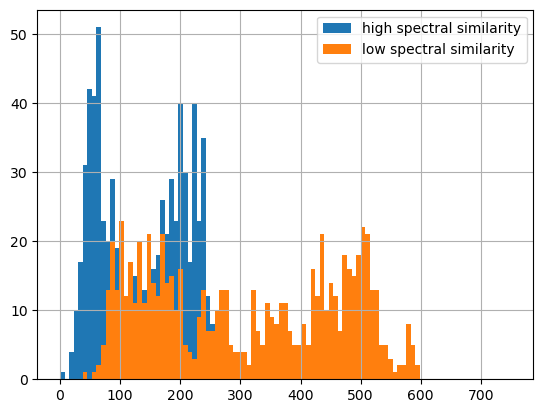

In [168]:

s = out.groupby(['dataset1','dataset2'])['rem_blink_score'].apply(lambda x: sum(x>0.01))#.unstack()
fig,ax = plt.subplots()
bins = np.linspace(0,750,100)
s.hist(ax=ax,bins=bins,label='high spectral similarity')
s = out.groupby(['dataset1','dataset2'])['rem_blink_score'].apply(lambda x: sum(x<0.01))#.unstack()
s.hist(ax=ax,bins=bins,label='low spectral similarity')

ax.legend()

In [169]:
g = [gg for _,gg in out.groupby(['dataset1','dataset2'])]
g = [gg.sort_values('rem_blink_score',ascending=False) for gg in g if sum(gg['rem_blink_score']>0.01)>305]
# fig,ax = plt.subplots()
# g[0]['rem_blink_score'].hist(ax=ax,bins=np.linspace(0,1,100),label='high similarity')
g[0]

,ref,query,rem_blink_score,dataset1,dataset2,predicted_formula_1,max_frag_intensity_1,num_frags_1,title_1,massive_id_1,predicted_formula_2,max_frag_intensity_2,num_frags_2,title_2,massive_id_2
371,20.0,13.0,0.520141,MSV000092114,MSV000092720,C19H28O8,114512.015625,13,GNPS - Chabo_Botswana_Waterholes_DissolvedOrga...,MSV000092114,C18H26O8,160620.031250,12,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,MSV000092720
444,7.0,16.0,0.519385,MSV000092114,MSV000092720,C17H18O9,183176.796875,21,GNPS - Chabo_Botswana_Waterholes_DissolvedOrga...,MSV000092114,C20H30O7,136482.421875,5,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,MSV000092720
611,2.0,22.0,0.519385,MSV000092114,MSV000092720,C18H24O8,213513.875000,19,GNPS - Chabo_Botswana_Waterholes_DissolvedOrga...,MSV000092114,C15H14O11,53076.972656,7,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,MSV000092720
796,18.0,28.0,0.509710,MSV000092114,MSV000092720,C19H24O8,119028.632812,18,GNPS - Chabo_Botswana_Waterholes_DissolvedOrga...,MSV000092114,C20H32O6,12498.247070,5,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,MSV000092720
192,15.0,7.0,0.457344,MSV000092114,MSV000092720,C18H26O8,136559.265625,18,GNPS - Chabo_Botswana_Waterholes_DissolvedOrga...,MSV000092114,C18H22O8,223735.906250,20,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,MSV000092720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,5.0,13.0,0.004974,MSV000092114,MSV000092720,C20H28O7,185453.281250,15,GNPS - Chabo_Botswana_Waterholes_DissolvedOrga...,MSV000092114,C18H26O8,160620.031250,12,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,MSV000092720
358,7.0,13.0,0.004974,MSV000092114,MSV000092720,C17H18O9,183176.796875,21,GNPS - Chabo_Botswana_Waterholes_DissolvedOrga...,MSV000092114,C18H26O8,160620.031250,12,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,MSV000092720
359,8.0,13.0,0.004974,MSV000092114,MSV000092720,C17H20O9,182014.734375,23,GNPS - Chabo_Botswana_Waterholes_DissolvedOrga...,MSV000092114,C18H26O8,160620.031250,12,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,MSV000092720
361,10.0,13.0,0.004974,MSV000092114,MSV000092720,C19H26O8,156648.875000,19,GNPS - Chabo_Botswana_Waterholes_DissolvedOrga...,MSV000092114,C18H26O8,160620.031250,12,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,MSV000092720


In [140]:
out

,ref,query,rem_blink_score,dataset1,dataset2,predicted_formula_1,max_frag_intensity_1,num_frags_1,predicted_formula_2,max_frag_intensity_2,num_frags_2
0,0.0,0.0,0.004974,MSV000092487,MSV000085555,C20H32O6,1.181588e+07,6,C20H30O7,1.076622e+07,8
34,0.0,2.0,0.004974,MSV000092487,MSV000085555,C20H32O6,1.181588e+07,6,C20H30O7,1.076622e+07,8
55,0.0,3.0,0.065264,MSV000092487,MSV000085555,C20H32O6,1.181588e+07,6,C20H30O7,1.076622e+07,8
79,0.0,4.0,0.066583,MSV000092487,MSV000085555,C20H32O6,1.181588e+07,6,C20H30O7,1.076622e+07,8
103,0.0,5.0,0.124479,MSV000092487,MSV000085555,C20H32O6,1.181588e+07,6,C20H30O7,1.076622e+07,8
...,...,...,...,...,...,...,...,...,...,...,...
435,22.0,19.0,0.004974,MSV000089688,MSV000089190,C16H16O10,1.404068e+04,13,C16H16O11,1.457226e+04,6
459,22.0,20.0,0.004974,MSV000089688,MSV000089190,C16H16O10,1.404068e+04,13,C16H16O11,1.457226e+04,6
477,22.0,21.0,0.004974,MSV000089688,MSV000089190,C16H16O10,1.404068e+04,13,C16H16O11,1.457226e+04,6
501,22.0,22.0,0.127527,MSV000089688,MSV000089190,C16H16O10,1.404068e+04,13,C16H16O11,1.457226e+04,6


In [151]:
def row_calc(x):
    frac = sum(x>0.01)/len(x)
    return pd.Series({'fraction':frac,'num':len(x),'num_similar':sum(x>0.01)})
    

g = out.groupby(['dataset1','dataset2'])['rem_blink_score'].apply(row_calc).unstack()
g.sort_values('fraction',ascending=False,inplace=True)
g.head(20)


fraction    num  num_similar
dataset1     dataset2                                  
MSV000089591 MSV000085025  0.666667    3.0          2.0
MSV000090798 MSV000091211  0.500000  174.0         87.0
             MSV000090695  0.460829  217.0        100.0
MSV000092487 MSV000091211  0.445161  155.0         69.0
             MSV000090695  0.439394  198.0         87.0
MSV000089061 MSV000091211  0.424460  139.0         59.0
MSV000092720 MSV000086993  0.414830  499.0        207.0
MSV000091211 MSV000090695  0.411765  204.0         84.0
MSV000089061 MSV000090695  0.411111  180.0         74.0
MSV000092487 MSV000089061  0.409465  486.0        199.0
MSV000092720 MSV000089688  0.405157  543.0        220.0
             MSV000087935  0.401826  438.0        176.0
MSV000090282 MSV000090695  0.401575  254.0        102.0
MSV000092720 MSV000087608  0.400621  644.0        258.0
MSV000092114 MSV000086993  0.396414  502.0        199.0
             MSV000087935  0.392523  428.0        168.0
MSV000092720 MSV000087572  0.390282  638.0        249.0
MSV000089361 MSV000090695  0.389764  254.0         99.0
MSV000085555 MSV000091211  0.384211  190.0         73.0
MSV000092720 MSV000089361  0.384181  708.0        272.0

In [ ]:

    if spec_slice.shape[0]<2:
        continue

    spec_slice['spectrum_nl_spectra'] = spec_slice.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
    nl_data_spectra = spec_slice['spectrum_nl_spectra'].tolist()
    data_pmzs = spec_slice['precursor_mz'].tolist()
    shifted_spectra = []
    for s,pmz in zip(nl_data_spectra,data_pmzs):
        temp = s.copy()
        temp[:,0] = pmz - temp[:,0]
        shifted_spectra.append(temp)

    discretized_spectra = blink.discretize_spectra(shifted_spectra, shifted_spectra, data_pmzs,  data_pmzs,
                                            bin_width=0.001, tolerance=frag_mz_tolerance, intensity_power=0.5, trim_empty=False, remove_duplicates=False, network_score=False)
    msms_score_min = 0
    msms_matches_min = 0
    nl_blink = at.do_blink(discretized_spectra,merged_node_data,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance)
    nl_blink.reset_index(inplace=True,drop=False)
    cols = ['ref','query']
    nl_blink[cols] = np.sort(nl_blink[cols],axis=1)
    nl_blink.drop_duplicates(subset=cols,inplace=True)
    nl_blink = nl_blink[nl_blink['ref']!=nl_blink['query']]
    idx = nl_blink['score']>1
    nl_blink.loc[idx,'score'] = 1
    # temp = nl_blink[nl_blink['score']>0.001].copy()
    # bins = np.logspace(np.log10(nl_blink['score'].min()),np.log10(nl_blink['score'].max()),100)
    bins = np.linspace(0,1,20)
    # sns.ecdfplot(nl_blink['score'],ax=ax)
    out.append({'formula':uni_form,'count_lt':sum(nl_blink['score']<0.8),'count_gt':sum(nl_blink['score']>=0.8)})
    ax[counter].hist(nl_blink['score'],bins=bins)
    ax[counter].set_title(uni_form)
    ax[counter].axvline(0.8,color='red')
    # ax.set_xlabel('MS2 neutral-loss spectral similarity score')
    # ax.set_ylabel('Cumulative number of pairs')
    # plt.show
    counter += 1
plt.tight_layout()


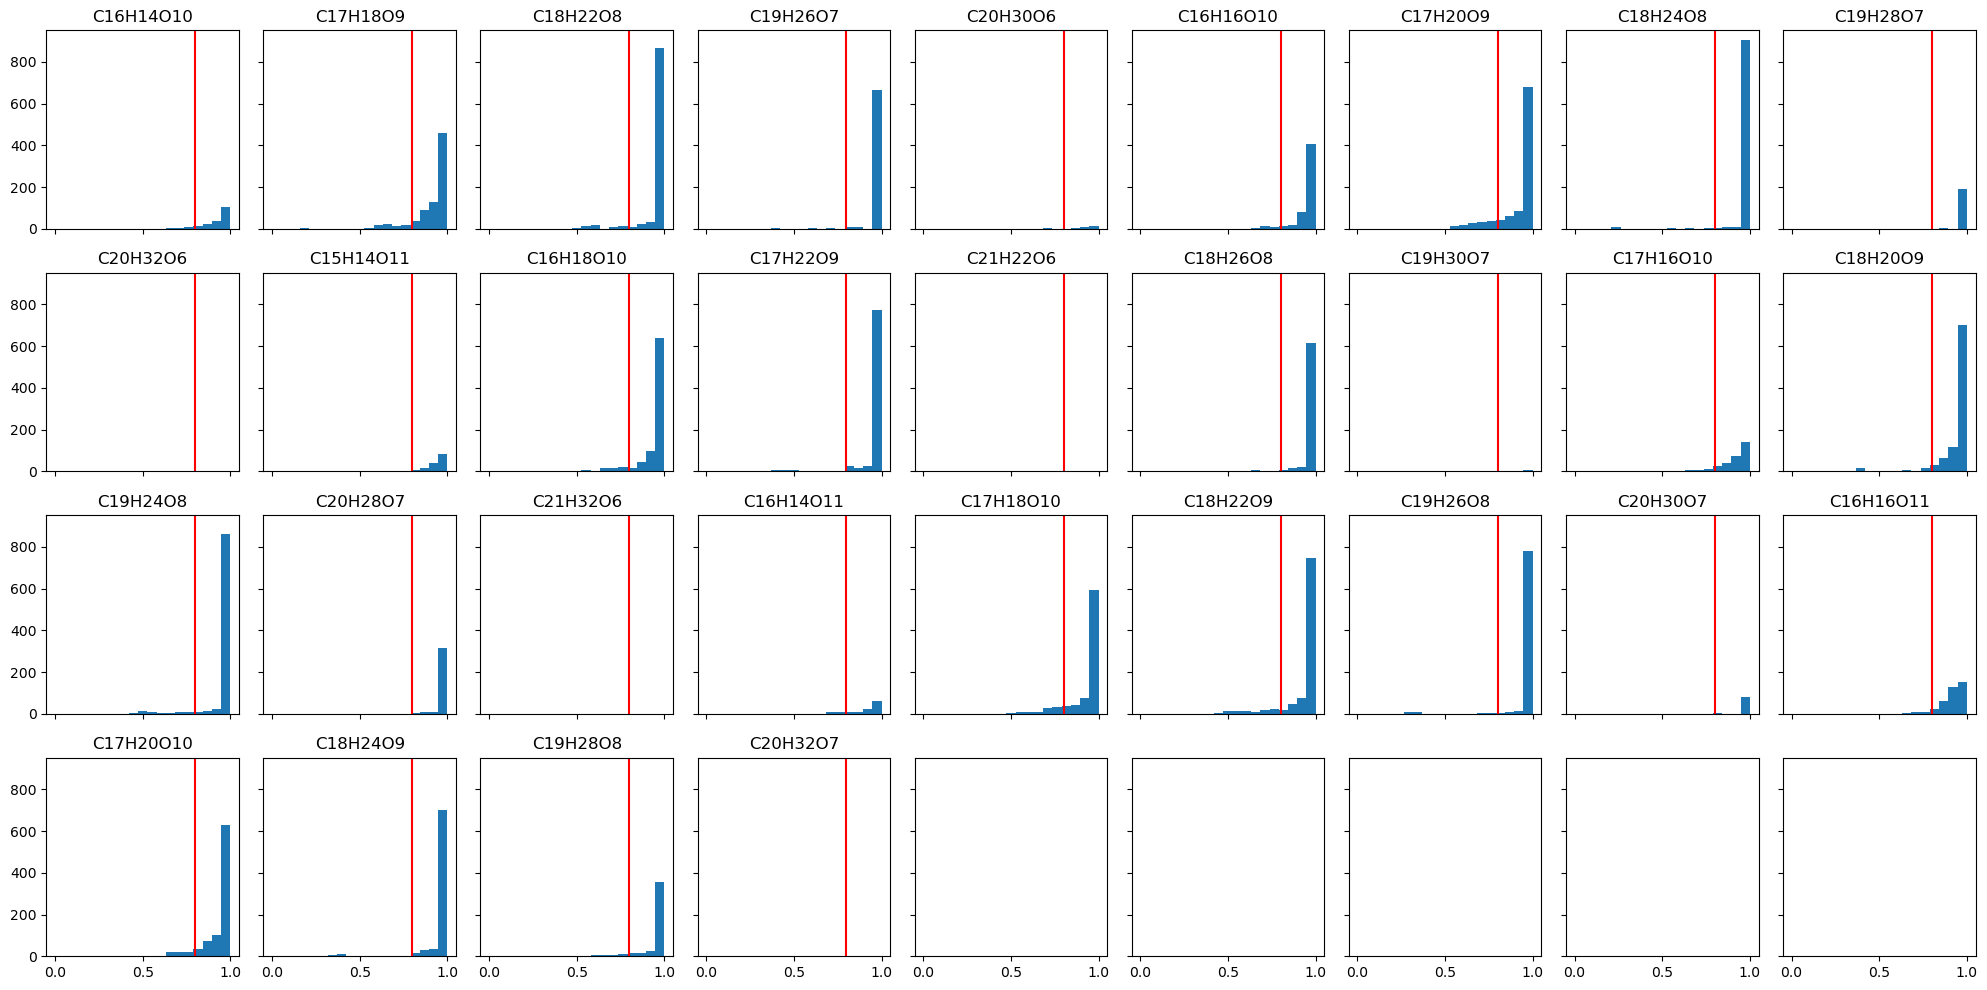

In [109]:

fig,ax = plt.subplots(ncols=9,nrows=4,figsize=(20,10),sharex=True,sharey=True)
ax = ax.flatten()
counter = 0

out = []
for uni_form in uni_df['Formula (of source compound)'].unique():
    spec_slice = all_df[all_df['predicted_formula']==uni_form].copy()
    spec_slice = spec_slice[pd.notna(spec_slice['mdm_mz_vals'] )]
    spec_slice['num_frags'] = spec_slice['mdm_mz_vals'].apply(len)
    spec_slice = spec_slice[spec_slice['num_frags']>10]
    spec_slice['max_frag_intensity'] = spec_slice['mdm_i_vals'].apply(np.max)
    # spec_slice.sort_values(by='max_frag_intensity',ascending=False,inplace=True)
    # spec_slice.drop_duplicates(subset='dataset',inplace=True)
    if spec_slice.shape[0]<2:
        continue

    spec_slice['spectrum_nl_spectra'] = spec_slice.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
    nl_data_spectra = spec_slice['spectrum_nl_spectra'].tolist()
    data_pmzs = spec_slice['precursor_mz'].tolist()
    shifted_spectra = []
    for s,pmz in zip(nl_data_spectra,data_pmzs):
        temp = s.copy()
        temp[:,0] = pmz - temp[:,0]
        shifted_spectra.append(temp)

    discretized_spectra = blink.discretize_spectra(shifted_spectra, shifted_spectra, data_pmzs,  data_pmzs,
                                            bin_width=0.001, tolerance=frag_mz_tolerance, intensity_power=0.5, trim_empty=False, remove_duplicates=False, network_score=False)
    msms_score_min = 0
    msms_matches_min = 0
    nl_blink = at.do_blink(discretized_spectra,merged_node_data,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance)
    nl_blink.reset_index(inplace=True,drop=False)
    cols = ['ref','query']
    nl_blink[cols] = np.sort(nl_blink[cols],axis=1)
    nl_blink.drop_duplicates(subset=cols,inplace=True)
    nl_blink = nl_blink[nl_blink['ref']!=nl_blink['query']]
    idx = nl_blink['score']>1
    nl_blink.loc[idx,'score'] = 1
    # temp = nl_blink[nl_blink['score']>0.001].copy()
    # bins = np.logspace(np.log10(nl_blink['score'].min()),np.log10(nl_blink['score'].max()),100)
    bins = np.linspace(0,1,20)
    # sns.ecdfplot(nl_blink['score'],ax=ax)
    out.append({'formula':uni_form,'count_lt':sum(nl_blink['score']<0.8),'count_gt':sum(nl_blink['score']>=0.8)})
    ax[counter].hist(nl_blink['score'],bins=bins)
    ax[counter].set_title(uni_form)
    ax[counter].axvline(0.8,color='red')
    # ax.set_xlabel('MS2 neutral-loss spectral similarity score')
    # ax.set_ylabel('Cumulative number of pairs')
    # plt.show
    counter += 1
plt.tight_layout()


Text(0.5, 0, 'fraction of spectra that differ by more than 80% similarity')

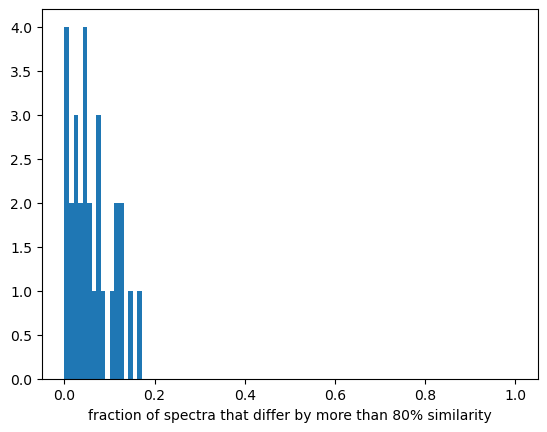

In [110]:
out = pd.DataFrame(out)
out = pd.DataFrame(out)
out['ratio'] = out['count_lt'] / (out['count_lt']+out['count_gt'])
fig,ax =plt.subplots()
bins = np.linspace(0,1,100)
ax.hist(out['ratio'],bins=bins)
ax.set_xlabel('fraction of spectra that differ by more than 80% similarity')

In [103]:

s = [g for _,g in all_df.groupby('predicted_formula')]
s = [ss for ss in s if ss.shape[0]>300]

out = []
for spec_slice in s:
    spec_slice = spec_slice[pd.notna(spec_slice['mdm_mz_vals'] )]
    spec_slice['num_frags'] = spec_slice['mdm_mz_vals'].apply(len)
    spec_slice = spec_slice[spec_slice['num_frags']>10]
    spec_slice['max_frag_intensity'] = spec_slice['mdm_i_vals'].apply(np.max)
    # spec_slice.sort_values(by='max_frag_intensity',ascending=False,inplace=True)
    # spec_slice.drop_duplicates(subset='dataset',inplace=True)
    if spec_slice.shape[0]<20:
        continue

    spec_slice['spectrum_nl_spectra'] = spec_slice.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
    nl_data_spectra = spec_slice['spectrum_nl_spectra'].tolist()
    data_pmzs = spec_slice['precursor_mz'].tolist()
    shifted_spectra = []
    for s,pmz in zip(nl_data_spectra,data_pmzs):
        temp = s.copy()
        temp[:,0] = pmz - temp[:,0]
        shifted_spectra.append(temp)

    discretized_spectra = blink.discretize_spectra(shifted_spectra, shifted_spectra, data_pmzs,  data_pmzs,
                                            bin_width=0.001, tolerance=frag_mz_tolerance, intensity_power=0.5, trim_empty=False, remove_duplicates=False, network_score=False)
    msms_score_min = 0
    msms_matches_min = 0
    nl_blink = at.do_blink(discretized_spectra,merged_node_data,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance)
    nl_blink.reset_index(inplace=True,drop=False)
    cols = ['ref','query']
    nl_blink[cols] = np.sort(nl_blink[cols],axis=1)
    nl_blink.drop_duplicates(subset=cols,inplace=True)
    nl_blink = nl_blink[nl_blink['ref']!=nl_blink['query']]
    idx = nl_blink['score']>1
    nl_blink.loc[idx,'score'] = 1
    
    out.append({'formula':spec_slice.iloc[0]['predicted_formula'],'count_lt':sum(nl_blink['score']<0.8),'count_gt':sum(nl_blink['score']>=0.8)})
    


Text(0.5, 0, 'fraction of spectra that differ by more than 80% similarity')

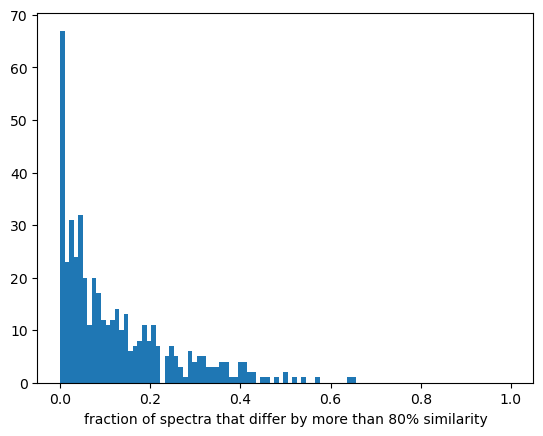

In [108]:
out = pd.DataFrame(out)
out['ratio'] = out['count_lt'] / (out['count_lt']+out['count_gt'])
fig,ax =plt.subplots()
bins = np.linspace(0,1,100)
ax.hist(out['ratio'],bins=bins)
ax.set_xlabel('fraction of spectra that differ by more than 80% similarity')

54

In [2]:

# tolerance in ppm between experimental signal and node mz
mz_ppm_tolerance = 5
peak_height_min = 1e4
num_datapoints_min = 10
# minimum MSMS score 
msms_score_min = 0.5

# minimum MSMS matching ion count
msms_matches_min = 3

# retention time range in minutes for feature finding
rt_range = [1, 700]

# tolerance in daltons used for calculating MS/MS similarity scores
frag_mz_tolerance = 0.05

In [3]:
from importlib import reload
at = reload(at)

In [4]:
# collect and merge required data and metadata
node_data = at.graph_to_df()
node_atlas = at.make_node_atlas(node_data, rt_range)
merged_node_data = at.merge_spectral_data(node_data)
# files_data = at.get_files_df(exp_dir)
# files = files_data['filename'].tolist()

INFO:root:Processing original_spectra.mgf
INFO:root:Processing nl_spectra.mgf


(6853, 9)
(6853, 9)


In [5]:
merged_node_data

,node_id,original_index,massive_id,no_extension_basename,title,description,precursor_mz,isolated_precursor_mz,rt,coisolated_precursor_count,...,spectrum_original_spectra,feature_id_nl_spectra,scans_nl_spectra,original_id_nl_spectra,pepmass_nl_spectra,precursor_mz_nl_spectra,rtinseconds_nl_spectra,charge_nl_spectra,mslevel_nl_spectra,spectrum_nl_spectra
0,847.0,847,MSV000090678,HBH0622_38_NEG,GNPS - HBH0622 Dissolved Organic Matter,DOM extraction in oceanic samples was carried ...,230.139362,230.139511,2.277,1.0,...,"[[184.87600708007812, 185.88272094726562, 184....",847,770,847,"(230.13936159781025, None)",230.139362,136.62,[1-],2,"[[168.1391143798828, 186.14947509765625, 212.1..."
1,0.0,0,MSV000092487,S56_neg_2,GNPS - Neckar and Spree River Water DOM,Non-target metabolomics of River DOM samples i...,200.128534,200.128876,6.159,1.0,...,"[[138.12791442871094, 113.09635162353516, 125....",0,0,0,"(200.1285344411897, None)",200.128534,369.54,[1-],2,"[[138.12791442871094, 156.1387176513672, 182.1..."
2,3568.0,3568,MSV000092487,S13_neg_2,GNPS - Neckar and Spree River Water DOM,Non-target metabolomics of River DOM samples i...,200.128543,200.128937,6.175,1.0,...,"[[138.12777709960938, 156.13873291015625, 182....",3568,2945,3568,"(200.1285431300143, None)",200.128543,370.50,[1-],2,"[[138.12777709960938, 156.13873291015625, 182...."
3,4680.0,4680,MSV000088823,DOM_Interlab-LCMS_Lab024_M_NEG_MS2_rep2,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,Interlab Study of LC-MS/MS analyis of Marine D...,230.148272,230.148209,16.316,1.0,...,"[[168.1477813720703, 186.1584930419922, 212.13...",4680,3729,4680,"(230.14827249269, None)",230.148272,978.96,[1-],2,"[[168.1477813720703, 186.1584930419922, 212.13..."
4,141.0,141,MSV000088823,DOM_Interlab-LCMS_Lab16_A_Neg_MS2_rep2,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,Interlab Study of LC-MS/MS analyis of Marine D...,188.056616,188.05661,1.704,1.0,...,"[[157.8631134033203, 151.8952178955078, 146.04...",141,126,141,"(188.0566155903552, None)",188.056616,102.24,[1-],2,"[[100.07701873779297, 126.05606079101562, 144...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6848,9722.0,9722,MSV000092487,S68_neg_1,GNPS - Neckar and Spree River Water DOM,Non-target metabolomics of River DOM samples i...,208.00721,208.061356,3.51,3.0,...,"[[164.018310546875, 165.9964141845703, 177.996...",9722,6745,9722,"(208.00721005087664, None)",208.007210,210.60,[1-],2,"[[164.018310546875, 165.9964141845703, 177.996..."
6849,9756.0,9756,MSV000089061,Soil_F3A_neg,GNPS - Tuebingen Forest Soil Meta-Metabolome,Non-targeted LC-MS/MS of Soil Meta-Metabolome ...,175.035101,174.955429,13.787,2.0,...,"[[59.0584602355957, 118.97237396240234, 132.98...",9756,6750,9756,"(175.0351010420437, None)",175.035101,827.22,[1-],2,"[[59.0584602355957, 118.97237396240234, 132.98..."
6850,9824.0,9824,MSV000092720,NEHLA_2_neg_15,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,Non-targeted 2D LC-MS/MS analysis (pos/neg ESI...,499.072619,499.146149,4.693,2.0,...,"[[305.1021423339844, 307.0826416015625, 323.11...",9824,6771,9824,"(499.0726185226949, None)",499.072619,281.58,[1-],2,"[[305.1021423339844, 307.0826416015625, 323.11..."
6851,9826.0,9826,MSV000090678,HBH0622_27a_NEG,GNPS - HBH0622 Dissolved Organic Matter,DOM extraction in oceanic samples was carried ...,325.097365,325.129364,4.524,1.0,...,"[[249.0826873779297, 289.0770263671875, 307.08...",9826,6772,9826,"(325.0973651327761, None)",325.097365,271.44,[1-],2,"[[249.0826873779297, 289.0770263671875, 307.08..."


In [8]:
df.columns

Index(['node_id', 'original_index', 'massive_id', 'no_extension_basename',
       'title', 'description', 'precursor_mz', 'isolated_precursor_mz', 'rt',
       'coisolated_precursor_count', 'predicted_formula', 'estimated_fdr',
       'predicted_mass', 'mass_error', 'num_mdm_frags', 'max_score_identity',
       'best_match_method_identity', 'max_matches_identity', 'name_identity',
       'inchi_key_identity', 'smiles_identity', 'formula_identity',
       'precursor_mz_identity', 'original_p2d2_index_identity',
       'isin_fticr_formula', 'dbe', 'dbe_ai', 'dbe_ai_mod', 'ai_mod', 'ai',
       'nosc', 'h_to_c', 'o_to_c', 'n_to_c', 'p_to_c', 'c', 'h', 'o', 'n', 's',
       'p', 'class_results', 'superclass_results', 'pathway_results',
       'class_results_propagated', 'superclass_results_propagated',
       'pathway_results_propagated', 'n_to_p', 'feature_id_original_spectra',
       'scans_original_spectra', 'original_id_original_spectra',
       'pepmass_original_spectra', 'precursor_m

In [11]:
df = merged_node_data.copy()
deltas = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/mdm_neutral_losses.csv')

df.reset_index(inplace=True,drop=True)
mass_diffs = [0] + deltas['mass'].tolist()
rem_df = wt.do_remblink_networking(df,df,mass_diffs=mass_diffs,
                                   spectra_attr='spectrum_nl_spectra')
# rem_df = wt.do_remblink_networking(out,df,spectra_attr='nl_spectrum')
rem_df.rename(columns={'rem_predicted_score':'rem_blink_score'},inplace=True)
cols = ['ref','query','rem_blink_score']
rem_df = rem_df[cols]
# print(rem_df.shape)
# rem_df = rem_df[rem_df['rem_blink_score']>0.1]
print(rem_df.shape)
cols = ['ref','query']
rem_df[cols] = np.sort(rem_df[cols],axis=1)
rem_df.drop_duplicates(subset=cols,inplace=True)
print(rem_df.shape)

Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
(12574891, 3)
(6290872, 3)


In [47]:
merged_node_data.reset_index(inplace=True,drop=True)
nl_data_spectra = merged_node_data['spectrum_nl_spectra'].tolist()
data_pmzs = merged_node_data['precursor_mz'].tolist()
data_pmzs[0] - nl_data_spectra[0]

array([[    62.00024722,     43.9898865 ,     18.01089785],
       [-15140.53739621,  -7675.84843137,  -5558.51200559]])

<function matplotlib.pyplot.show(close=None, block=None)>

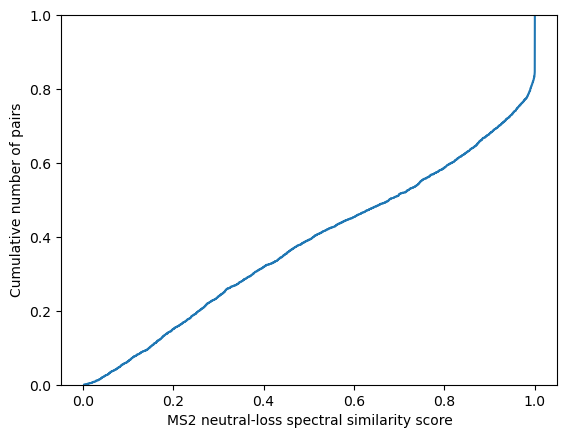

In [48]:
nl_data_spectra = merged_node_data['spectrum_nl_spectra'].tolist()
data_pmzs = merged_node_data['precursor_mz'].tolist()
shifted_spectra = []
for s,pmz in zip(nl_data_spectra,data_pmzs):
    temp = s.copy()
    temp[:,0] = pmz - temp[:,0]
    shifted_spectra.append(temp)

discretized_spectra = blink.discretize_spectra(shifted_spectra, shifted_spectra, data_pmzs,  data_pmzs,
                                        bin_width=0.001, tolerance=frag_mz_tolerance, intensity_power=0.5, trim_empty=False, remove_duplicates=False, network_score=False)
msms_score_min = 0
msms_matches_min = 0
nl_blink = at.do_blink(discretized_spectra,merged_node_data,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance)
nl_blink.reset_index(inplace=True,drop=False)
cols = ['ref','query']
nl_blink[cols] = np.sort(nl_blink[cols],axis=1)
nl_blink.drop_duplicates(subset=cols,inplace=True)
nl_blink = nl_blink[nl_blink['ref']!=nl_blink['query']]
idx = nl_blink['score']>1
nl_blink.loc[idx,'score'] = 1
fig,ax = plt.subplots()
# temp = nl_blink[nl_blink['score']>0.001].copy()
# bins = np.logspace(np.log10(nl_blink['score'].min()),np.log10(nl_blink['score'].max()),100)
# bins = np.linspace(nl_blink['score'].min(),nl_blink['score'].max(),100)
sns.ecdfplot(nl_blink['score'],ax=ax)
# ax.hist(nl_blink['score'],bins=bins)
ax.set_xlabel('MS2 neutral-loss spectral similarity score')
ax.set_ylabel('Cumulative number of pairs')
plt.show


In [52]:
import networkx as nx

# Filter the merged_node_data based on nl_blink_score > 0.9
filtered_data = nl_blink[nl_blink['score'] > 0.95]

network = nx.from_pandas_edgelist(filtered_data, source='ref', target='query')
nx.write_graphml(network, 'network.graphml')
# Optional: You can further customize the network visualization or perform network analysis using NetworkX functions.

<function matplotlib.pyplot.show(close=None, block=None)>

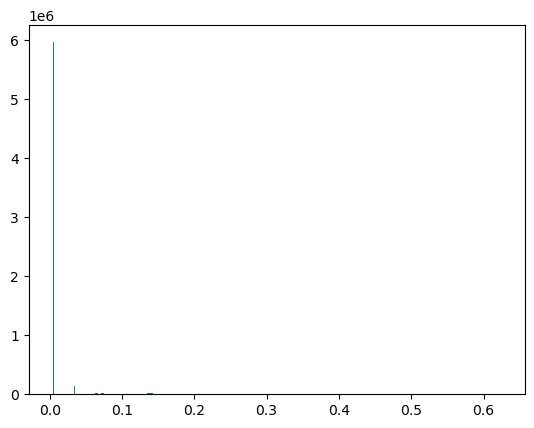

In [22]:
import seaborn as sns
fig,ax = plt.subplots()
temp = rem_df[rem_df['rem_blink_score']>0.001].copy()
bins = np.logspace(np.log10(temp['rem_blink_score'].min()),np.log10(temp['rem_blink_score'].max()),100)
ax.hist(temp['rem_blink_score'],bins=bins)
plt.show